# Time-series k-means clustering with Dynamic Time Warping

[Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping) (DTW) is a technique for time-series comparison. In this notebook we will use DTW as a core metric to perform _k_-means clustering of time-series data derived from the vectors of different words in different time slices. The goal is to cluster the semantic trajectories of different words in order to get insights into the several ways in which a word can undergo meaning change in the same timespan. To do so, we use the [implementation of this method in the `tslearn` library](https://tslearn.readthedocs.io/en/stable/user_guide/clustering.html).

In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, KShape
from scipy import spatial

/Users/npedrazzini/Desktop/LwMWordEmb/.venv/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Create subdir for all outputs of this notebook if it does not exist already:

In [2]:
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

### Load pre-trained diachronic embeddings

Change the following to the path to the folder containing the aligned diachonic models:

In [3]:
pathtomodels = '../../outputs/lwmhmdwhole/aligned'

List all models in the folder and sort them (so that we can identify the most recent time slice):

In [4]:
allmodels = sorted(glob(f'{pathtomodels}/*.model'))

Load the model for the most recent time slice:

In [5]:
lastmodel = Word2Vec.load(allmodels[-1])

Get the 'name' of each time slice (retrieved from the name of the model):

In [6]:
slices_names = []
for i in range(len(allmodels)):
    slice_name = allmodels[i].split('/')[-1].split('.model')[0]
    slices_names.append(slice_name)

### Define words to analyse

Give a list of words you wish to submit to the changepoint detection analysis:

In [7]:
words = ['machine','traffic','train','coach','wheel','fellow','railway','match']

Define function for calculating cosine similarity:

In [8]:
def cosine_similarity(word,modelx,modely):
  sc = 1-spatial.distance.cosine(modelx.wv[word], modely.wv[word])
  return sc

Iterate over all words and for each word iterate over each decade. Calculate the cosine similarity between the vector of the same word in the last time slice and each of the previous time slices. Write the list of cosine similarity scores under the relevant column:

In [ ]:
cosmatrix = []
columns = ['timeslice'] + words
df = pd.DataFrame(columns=columns)
df['timeslice'] = slices_names
for word in words:
    print(f'Now processing {word}')
    col = []
    for i in range(len(allmodels)):
        prevmodel = Word2Vec.load(allmodels[i])
        try:
            col.append(cosine_similarity(word,prevmodel,lastmodel))
        except KeyError:
            col.append('key_not_present')
    df[word] = col

Now processing machine
Now processing traffic
Now processing train
Now processing coach


If you wish, you can save the `df`:

In [27]:
df.to_csv('./outputs/compare_cosine_change.csv',index=False)

Have a look at the df:

In [28]:
df

,timeslice,machine,traffic,train,coach,wheel,fellow,railway,match
0,1800s,0.538324,0.420651,0.324786,0.489400,0.402803,0.479353,0.459577,0.554676
1,1810s,0.496138,0.449990,0.372578,0.460499,0.459370,0.589156,0.470775,0.527800
2,1820s,0.545932,0.482117,0.328774,0.441508,0.519986,0.582866,0.414534,0.577189
3,1830s,0.515663,0.544893,0.583711,0.651554,0.634569,0.611102,0.584951,0.549253
4,1840s,0.554430,0.607245,0.748666,0.623944,0.672513,0.623651,0.577083,0.581258
5,1850s,0.573959,0.609152,0.779634,0.597136,0.498528,0.628994,0.673453,0.577026
6,1860s,0.608009,0.644658,0.761839,0.603736,0.543629,0.692641,0.609641,0.672848
7,1870s,0.607793,0.772956,0.811547,0.637981,0.652446,0.729383,0.722852,0.685755
8,1880s,0.577767,0.765621,0.831359,0.611826,0.563883,0.786354,0.795577,0.757252
9,1890s,0.625799,0.824597,0.859910,0.688646,0.713338,0.844123,0.832950,0.820066


Create a time series for all terms in `words`:

In [29]:
mySeries = []
for word in words:
    df2 = df.loc[:,["timeslice",word]]
    # While we are at it I just filtered the columns that we will be working on
    df2.set_index("timeslice",inplace=True)
    # set the date columns as index
    df2.sort_index(inplace=True)
    # and lastly, ordered the data according to our date index
    mySeries.append(df2)


### K-Means clustering with DTW

First find optimal number of clusters using `KShape` from `tslearn`. 
Define some parameters (complete list [here](https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.KShape.html#tslearn.clustering.KShape)). 

Note: `clusters_to_try` is not directly passed on to `KShape`, but it is the maximum number we iteratively pass to the `n_clusters` parameter. E.g., if we choose `4`, then there will be 4 iterations, with `n_clusters` starting from `1` at the first loop and ending with `4` at the fourth loop. If `clusters_to_try` is too high for the method, you will get an error saying so, at which point you will need to adjust the variable and run the cell again.

In [35]:
max_iter = 100
n_init = 4
random_state = 19051992
verbose=True
clusters_to_try = 4

Now generate elbow graph:

Init 1
0.434 --> 0.332 --> 0.265 --> 0.220 --> 0.191 --> 0.174 --> 0.168 --> 0.176 --> 
Init 2
0.434 --> 0.332 --> 0.265 --> 0.220 --> 0.191 --> 0.174 --> 0.168 --> 0.176 --> 
Init 3
0.434 --> 0.332 --> 0.265 --> 0.220 --> 0.191 --> 0.174 --> 0.168 --> 0.176 --> 
Init 4
0.434 --> 0.332 --> 0.265 --> 0.220 --> 0.191 --> 0.174 --> 0.168 --> 0.176 --> 
Init 1
0.430 --> 0.330 --> 0.264 --> 0.219 --> 0.191 --> 0.174 --> 0.167 --> 0.175 --> 
Init 2
0.429 --> 0.329 --> 0.263 --> 0.218 --> 0.190 --> 0.173 --> 0.167 --> 0.175 --> 
Init 3
0.431 --> 0.329 --> 0.263 --> 0.218 --> 0.190 --> 0.173 --> 0.167 --> 0.175 --> 
Init 4
0.430 --> 0.330 --> 0.264 --> 0.219 --> 0.191 --> 0.174 --> 0.167 --> 0.175 --> 
Init 1
Resumed because of empty cluster
Init 1
0.427 --> 0.327 --> 0.262 --> 0.218 --> 0.190 --> 0.173 --> 0.167 --> 0.175 --> 
Init 2
0.426 --> 0.327 --> 0.262 --> 0.218 --> 0.190 --> 0.173 --> 0.167 --> 0.175 --> 
Init 3
Resumed because of empty cluster
Init 3
0.427 --> 0.327 --> 0.262 --> 0.2

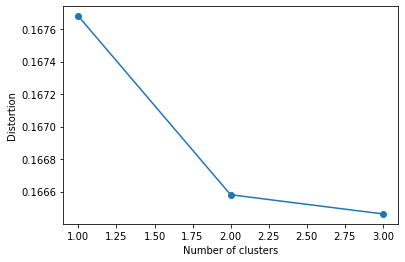

In [36]:
distortions = []

# Calculated from 1~4 clusters. Change "4" in "range(1,4)" to try out different numbers of clusters
for i  in range(1,clusters_to_try):
    ks = KShape(n_clusters=i, max_iter=max_iter, n_init=n_init, random_state=random_state, verbose=verbose)
    # Run clustering calculations
    ks.fit(mySeries)
    # ks.fit gives ks.inertia_
    distortions.append(ks.inertia_)

plt.plot(range(1,clusters_to_try), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Based on the elbow method above, change number of optimal clusters (this is where the 'elbow' is sharper):

In [31]:
opt_num_clusters = 2

Train a _k_-means model using the number of clusters shown to be optimal. First define some parameters (full list [here](https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html#tslearn.clustering.TimeSeriesKMeans)):

In [37]:
n_clusters = opt_num_clusters
max_iter = 100 # default: 50
n_init = 1 # default: 1
dtw_inertia = True # default: False
verbose = False # default: False
random_state = 19051992 
init = 'k-means++' # default: 'k-means++'

In [38]:
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",
                         max_iter=max_iter, random_state=random_state, 
                         n_init=n_init, dtw_inertia=dtw_inertia, 
                         verbose=verbose, init=init)
labels = model.fit_predict(mySeries)
labels = list(labels)

Sublot timeseries according to clusters:

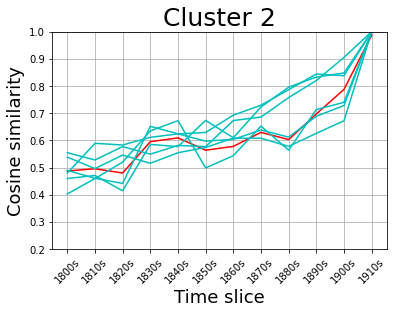

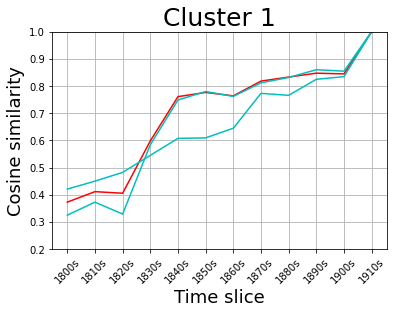

In [39]:
uniquelabels = list(dict.fromkeys(labels))
for unique in uniquelabels:
    plt.figure()
    plt.ylim(0.2, 1)
    plt.xlabel('Time slice',fontsize=18)
    plt.xticks(rotation = 45)
    plt.ylabel('Cosine similarity',fontsize=18)
    plt.grid(True)
    plt.plot(model.cluster_centers_[unique], "r-")
    plt.title(f"Cluster {unique + 1}",fontsize=25)
    for i in range(len(labels)):
        if labels[i] == unique:
            plt.plot(mySeries[i],"c-")
    plt.savefig(f'outputs/cluster{unique}.png')
        

See which words belong to which clusters:

In [34]:
names_for_labels = [f"Cluster {label+1}" for label in labels]
labelsdf = pd.DataFrame(zip(words,names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster")
labelsdf


,Series,Cluster
0,machine,Cluster 1
3,coach,Cluster 1
4,wheel,Cluster 1
1,traffic,Cluster 2
2,train,Cluster 2
5,fellow,Cluster 2
6,railway,Cluster 2
7,match,Cluster 2
